https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

In [1]:
#@title
!pip install -U --pre tensorflow=="2.2.0"

     |████████████████████████████████| 516.2MB 35kB/s 
     |████████████████████████████████| 460kB 91kB/s 
     |████████████████████████████████| 3.0MB 52.6MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

In [ ]:
import psutil
import humanize
import os
import GPUtil as GPU

In [ ]:
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  |     Proc size: 116.4 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total     15109MB


In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2603, done.
remote: Counting objects: 100% (2603/2603), done.
remote: Compressing objects: 100% (2166/2166), done.
remote: Total 2603 (delta 647), reused 1233 (delta 404), pack-reused 0
Receiving objects: 100% (2603/2603), 32.57 MiB | 30.15 MiB/s, done.
Resolving deltas: 100% (647/647), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1644828 sha256=7b322625e35a2b1e53ed41d488b4eb426a99a14e607423ed05b70b94c6aab362
  Stored in directory: /tmp/pip-ephem-wheel-cache-xhq9y1vl/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=14948d880e11482571fe8ca8ac625730fe69886860d8ec305b9b223d7a21b0d7
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78532 sha256=a7557545e22d15bc84749c5c2350fa0adcb2764647e420f400e43f2d34f23716
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=bfbe78a1397395330a19db28e0fb06439af6e11986a60a6f2520

ERROR: multiprocess 0.70.11.1 has requirement dill>=0.3.3, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.29.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [4]:
import matplotlib
import matplotlib.pyplot as plt
import pickle

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

import gc

%matplotlib inline

In [5]:
def reshape_grayscale_to_rgb_channel(previous_image, current_image, next_image):
  single_channel_previous_3d = previous_image.reshape((previous_image.shape[0], previous_image.shape[1], 1))
  single_channel_current_3d = current_image.reshape((current_image.shape[0], current_image.shape[1], 1))
  single_channel_next_3d = next_image.reshape((next_image.shape[0], next_image.shape[1], 1))
  return np.concatenate((single_channel_previous_3d, single_channel_current_3d, single_channel_next_3d), axis=2)

In [6]:
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  grayscale_image = np.array(image.getdata()).reshape(
      (im_height, im_width)).astype(np.uint8) # WYZ: update for grayscale images
  return grayscale_image

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=0.5)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)

In [7]:
def load_3d_stack(directory, previous_image_filename, current_image_filename, next_image_filename):
  previous_image_np = load_image_into_numpy_array(os.path.join(directory, previous_image_filename))
  current_image_np = load_image_into_numpy_array(os.path.join(directory, current_image_filename))
  next_image_np = load_image_into_numpy_array(os.path.join(directory, next_image_filename))
  return reshape_grayscale_to_rgb_channel(previous_image_np, current_image_np, next_image_np)

In [8]:
# load our data rather than sample data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


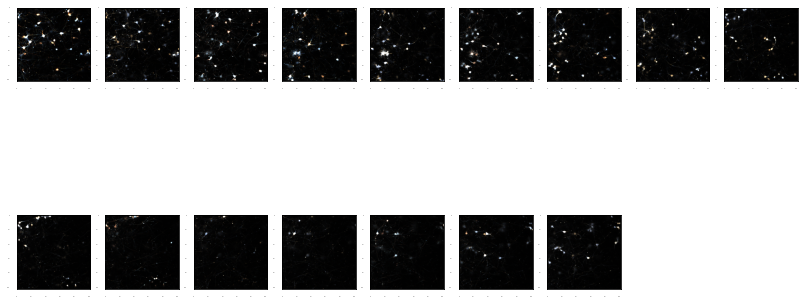

In [ ]:
# Load images and visualize
train_image_dir = '/content/drive/MyDrive/data/original/'
train_images_np = []
for j in range(0, 2):
  for i in range(1, 9):
    image_path_previous = 'D7_010_I5_Before00000' + str(j) + str(i - 1) + '9.jpg'
    image_path_current = 'D7_010_I5_Before00000' + str(j) + str(i) + '0.jpg'
    image_path_next = 'D7_010_I5_Before00000' + str(j) + str(i) + '1.jpg'
    train_images_np.append(load_3d_stack(train_image_dir, image_path_previous, image_path_current, image_path_next))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
  plt.subplot(2, 9, idx+1)
  plt.imshow(train_image_np)
plt.show()

In [ ]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)


#gt_boxes = [
#             np.array([[0.436, 0.591, 0.629, 0.712]], dtype=np.float32),#
#             np.array([[0.539, 0.583, 0.73, 0.71]], dtype=np.float32),
#             np.array([[0.464, 0.414, 0.626, 0.548]], dtype=np.float32),
#            np.array([[0.313, 0.308, 0.648, 0.526]], dtype=np.float32),
#            np.array([[0.256, 0.444, 0.484, 0.629]], dtype=np.float32)
#]

In [ ]:
#with open('/content/drive/MyDrive/Cell_Counting_3D/gt_boxes_nomin', 'wb') as f:
#  pickle.dump(gt_boxes, f)

In [ ]:
with open('/content/drive/MyDrive/Cell_Counting_3D/gt_boxes_nomin', 'rb') as f:
  gt_boxes = pickle.load(f)

In [9]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
cell_class_id = 1
num_classes = 1

category_index = {cell_class_id: {'id': cell_class_id, 'name': 'cell'}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
    train_images_np, gt_boxes):
  train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
      train_image_np, dtype=tf.float32), axis=0))
  gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
  zero_indexed_groundtruth_classes = tf.convert_to_tensor(
      np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
  gt_classes_one_hot_tensors.append(tf.one_hot(
      zero_indexed_groundtruth_classes, num_classes))
print('Done prepping data.')

NameError: ignored

In [ ]:
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(0, 16):
  plt.subplot(4, 4, idx+1)
  plot_detections(
      train_images_np[idx],
      gt_boxes[idx],
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
      np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.float32),
      category_index)
plt.show()

In [ ]:

# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz
!tar -xf ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.tar.gz

In [ ]:
ls 'ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8/saved_model'

In [10]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = '/content/drive/MyDrive/Cell_Counting_3D/checkpoint/new_config/pipeline.config'
checkpoint_path = '/content/drive/MyDrive/Cell_Counting_3D/checkpoint/ckpt-10'
#pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8.config'
# checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

# Load pipeline config and build a detection model.
#
# Since we are working off of a COCO architecture which predicts 90
# class slots by default, we override the `num_classes` field here to be just
# one (for our new rubber ducky class).
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
      model_config=model_config, is_training=True)

# Set up object-based checkpoint restore --- RetinaNet has two prediction
# `heads` --- one for classification, the other for box regression.  We will
# restore the box regression head but initialize the classification head
# from scratch (we show the omission below by commenting out the line that
# we would add if we wanted to restore both heads)
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
     _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
    )
fake_model = tf.compat.v2.train.Checkpoint(
          _feature_extractor=detection_model._feature_extractor,
          _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

# Run model through a dummy image so that variables are created
image, shapes = detection_model.preprocess(tf.zeros([1, 1024, 1024, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
# print('Weights restored!')

Building model and restoring weights for fine-tuning...


In [ ]:
detection_model.trainable_variables

In [ ]:
learning_rate = 0.01

# Select variables in top layers to fine-tune.
trainable_variables = detection_model.trainable_variables
to_fine_tune = trainable_variables # train everything
# prefixes_to_train = [
#   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
#   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
# for var in trainable_variables:
#   if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
#     to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # Use tf.function for a bit of speed.
  # Comment out the tf.function decorator if you want the inside of the
  # function to run eagerly.
  @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(batch_size * [[1024, 1024, 3]], dtype=tf.int32)
    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)
    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)
      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
      gradients = tape.gradient(total_loss, vars_to_fine_tune)
      optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
    return total_loss

  return train_step_fn

optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

In [ ]:
# Save new pipeline config
new_pipeline_proto = config_util.create_pipeline_proto_from_configs(configs)
config_util.save_pipeline_config(new_pipeline_proto, '/content/drive/MyDrive/Cell_Counting_3D/checkpoint/new_config')
exported_ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt_manager = tf.train.CheckpointManager(
exported_ckpt, directory="/content/drive/MyDrive/Cell_Counting_3D/checkpoint/", max_to_keep=5)

INFO:tensorflow:Writing pipeline config file to /content/drive/MyDrive/Cell_Counting_3D/checkpoint/new_config/pipeline.config


In [ ]:
tf.keras.backend.set_learning_phase(True)

# These parameters can be tuned; since our training set has 5 images
# it doesn't make sense to have a much larger batch size, though we could
# fit more examples in memory if we wanted to.
batch_size = 3
num_batches = 100



print('Start fine-tuning!', flush=True)
for idx in range(num_batches):
  gc.collect()
  # Grab keys for a random subset of examples
  all_keys = list(range(len(train_images_np)))
  random.shuffle(all_keys)
  example_keys = all_keys[:batch_size]

  # Note that we do not do data augmentation in this demo.  If you want a
  # a fun exercise, we recommend experimenting with random horizontal flipping
  # and random cropping :)
  gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
  gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
  image_tensors = [train_image_tensors[key] for key in example_keys]

  # Training step (forward pass + backwards pass)
  total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

  if idx % 10 == 0:
    print('batch ' + str(idx) + ' of ' + str(num_batches)
    + ', loss=' +  str(total_loss.numpy()), flush=True)
    ckpt_manager.save()

print('Done fine-tuning!')

Start fine-tuning!


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:434: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


batch 0 of 100, loss=0.087997854
batch 10 of 100, loss=0.078981556
batch 20 of 100, loss=0.070292555
batch 30 of 100, loss=0.06139514
batch 40 of 100, loss=0.110014826
batch 50 of 100, loss=0.09140439
batch 60 of 100, loss=0.08185841
batch 70 of 100, loss=0.07465558
batch 80 of 100, loss=0.0761794
batch 90 of 100, loss=0.08414369
Done fine-tuning!


In [ ]:
%load_ext tensorboard
%tensorboard --logdir '/content/training/train'

In [ ]:
test_image_dir = '/content/drive/MyDrive/data/original/'
test_images_np = []
for i in range(2, 187):
  image_path_previous = 'D7_010_I5_Before00000' + str(i - 1).zfill(3) + '.jpg'
  image_path_current = 'D7_010_I5_Before00000' + str(i).zfill(3) + '.jpg'
  image_path_next = 'D7_010_I5_Before00000' + str(i + 1).zfill(3) + '.jpg'
  test_images_np.append(np.expand_dims(
      load_3d_stack(test_image_dir, image_path_previous, image_path_current, image_path_next), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  plot_detections(
      test_images_np[i][0],
      detections['detection_boxes'][0].numpy(),
      detections['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detections['detection_scores'][0].numpy(),
      category_index, figsize=(15, 20), image_name="/content/drive/MyDrive/Cell_Counting_3D/gif_frames/gif_frame_" + ('%03d' % i) + ".jpg")

In [ ]:
imageio.plugins.freeimage.download()

anim_file = '/content/drive/MyDrive/Cell_Counting_3D/cells_3D.gif'

filenames = glob.glob('/content/drive/MyDrive/Cell_Counting_3D/gif_frames/gif_frame_*.jpg')
filenames = sorted(filenames)
last = -1
images = []

# filter to first 30 frames
# filenames=filenames[0:30]

for filename in filenames:
  image = imageio.imread(filename)
  images.append(image)

imageio.mimsave(anim_file, images, 'GIF-FI', fps=2)

display(IPyImage(open(anim_file, 'rb').read()))

In [11]:
test_image_dir = '/content/drive/MyDrive/data/original/'
test_images_np = []
image_path_previous = 'D7_010_I5_Before00000047.jpg'
image_path_current = 'D7_010_I5_Before00000048.jpg'
image_path_next = 'D7_010_I5_Before00000049.jpg'
test_images_np.append(np.expand_dims(
    load_3d_stack(test_image_dir, image_path_previous, image_path_current, image_path_next), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly
@tf.function
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)

# Note that the first frame will trigger tracing of the tf.function, which will
# take some time, after which inference should be fast.

label_id_offset = 1
for i in range(len(test_images_np)):
  input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
  detections = detect(input_tensor)

  # plot_detections(
  #     test_images_np[i][0],
  #     detections['detection_boxes'][0].numpy(),
  #     detections['detection_classes'][0].numpy().astype(np.uint32)
  #     + label_id_offset,
  #     detections['detection_scores'][0].numpy(),
  #     category_index, figsize=(15, 20), image_name="/content/drive/MyDrive/Cell_Counting_3D/gif_frames/gif_frame_" + ('%03d' % i) + ".jpg")

In [13]:
detections['detection_scores'][0].numpy()

array([0.99856514, 0.9961443 , 0.9923464 , 0.9864058 , 0.978832  ,
       0.97197354, 0.9539964 , 0.95375746, 0.9365097 , 0.92841905,
       0.92008287, 0.9114861 , 0.9086639 , 0.8056376 , 0.7252264 ,
       0.7215913 , 0.69777054, 0.6484242 , 0.57996106, 0.57565904,
       0.51021147, 0.47152144, 0.4686603 , 0.467523  , 0.44367322,
       0.41381386, 0.3991237 , 0.38597658, 0.3786228 , 0.3338697 ,
       0.23996554, 0.207365  , 0.1998479 , 0.187982  , 0.1859127 ,
       0.17997305, 0.16957651, 0.16394731, 0.1610835 , 0.1607888 ,
       0.15933205, 0.14777781, 0.13739412, 0.13424525, 0.12923412,
       0.12316543, 0.12283079, 0.11846644, 0.11835101, 0.10818278,
       0.10778749, 0.10527304, 0.10217967, 0.10012272, 0.09826414,
       0.09813117, 0.0978863 , 0.09712474, 0.09671529, 0.09464853,
       0.09463455, 0.09322874, 0.09107932, 0.0906951 , 0.09053171,
       0.08568306, 0.08383445, 0.0784947 , 0.07766461, 0.07679182,
       0.07504731, 0.07135411, 0.07042389, 0.07040554, 0.07013